# Comparison of online NICA algorithms on synthetic sparse uniform sources

### Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from nica_algorithms import bio_nica_direct, bio_nica_indirect, two_layer_nsm, nonnegative_pca
from util import permutation_error, add_fill_lines

### Load desired dataset

In [6]:
dataset = '3-dim_synthetic'
# dataset = '10-dim_synthetic'

S = np.load(f'datasets/{dataset}/sources.npy')
X = np.load(f'datasets/{dataset}/mixtures.npy')

s_dim = S.shape[0]
x_dim = X.shape[0]
samples = S.shape[1]

### Online algorithms

In [7]:
trials = 1 # set the number of trials

bionica_indirect_err = np.zeros((trials,samples))
bionica_direct_err = np.zeros((trials,samples))
nsm_err = np.zeros((trials,samples))
npca_err = np.zeros((trials,samples))

In [23]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} of out {trials}:')
    
    # Random permutation of the mixtures

    idx = np.random.permutation(samples)
    
    # Noncentered whitening for Nonnegative PCA

    sig, U = np.linalg.eig(np.cov(X))

    X_white = U@np.diag(1./np.sqrt(sig))@U.T@X
    
    n_dim = s_dim
    
    eta = 1e-3
    
    bionica_indirect = bio_nica_indirect(s_dim, x_dim, n_dim, eta0=eta, decay=0)
    bionica_direct = bio_nica_direct(s_dim, x_dim, eta0=eta, decay=0)
    nsm = two_layer_nsm(s_dim, x_dim, eta0=eta, decay=0)
    npca = nonnegative_pca(s_dim, x_dim, eta0=eta, decay=0)
    
    bionica_direct_Y = np.zeros((s_dim,samples))
    bionica_indirect_Y = np.zeros((s_dim,samples))
    nsm_Y = np.zeros((s_dim,samples))
    npca_Y = np.zeros((s_dim,samples))
    
    print('Running online algorithms...')
    
    for i_sample in range(samples):

        x = X[:,idx[i_sample]]
        x_white = X_white[:,idx[i_sample]]
        
        bionica_indirect_Y[:,i_sample] = bionica_indirect.fit_next(x)
        bionica_direct_Y[:,i_sample] = bionica_direct.fit_next(x)
        nsm_Y[:,i_sample] = nsm.fit_next(x)
        npca_Y[:,i_sample] = npca.fit_next(x_white)
        
        # if a neuron hasn't fired by the 100th iteration, we flip the feedforward weights:
        
        if i_sample==100:
            for j in range(s_dim):
                if bionica_indirect_Y[j,0:i_sample].sum()==0:
                    bionica_indirect.flip_weights(j)
                if bionica_direct_Y[j,0:i_sample].sum()==0:
                    bionica_direct.flip_weights(j)
                if nsm_Y[j,0:i_sample].sum()==0:
                    nsm.flip_weights(j)
                if npca_Y[j,0:i_sample].sum()==0:
                    npca.flip_weights(j)
        
    print('Computing errors...')

    bionica_indirect_err[i_trial,:] = permutation_error(S[:,idx],bionica_indirect_Y)
    bionica_direct_err[i_trial,:] = permutation_error(S[:,idx],bionica_direct_Y)
    nsm_err[i_trial,:] = permutation_error(S[:,idx],nsm_Y)
    npca_err[i_trial,:] = permutation_error(S[:,idx],npca_Y)

    print(f'Final Bio-NICA (indirect) permutation error: {bionica_indirect_err[i_trial,-1]}')
    print(f'Final Bio-NICA (direct) permutation error: {bionica_direct_err[i_trial,-1]}')
    print(f'Final 2-layer NSM permutation error: {nsm_err[i_trial,-1]}')
    print(f'Final Nonnegative PCA permutation error: {npca_err[i_trial,-1]}')

Trial 1 of out 1:
Running online algorithms...
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
PP.T close to degenerate
Computing errors...
Final Bio-NICA (indirect) permutation error: 1.3906235143426384
Final Bio-NICA (direct) permutation error: 0.027559837414870128
Final 2-layer NSM permutation error: 0.038030891897274
Final Nonnegative PCA permutation error: 0.07893823057132256


### Comparison plots

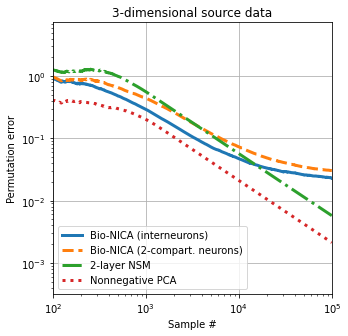

In [22]:
linewidth = 3

t = list(range(samples))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, bionica_indirect_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA (interneurons)'})
add_fill_lines(ax, t, bionica_direct_err, plot_kwargs={'ls': '--', 'lw': linewidth, 'label': 'Bio-NICA (2-compart. neurons)'})
add_fill_lines(ax, t, nsm_err, plot_kwargs={'ls': '-.', 'lw': linewidth, 'label': '2-layer NSM'})
add_fill_lines(ax, t, npca_err, plot_kwargs={'ls': ':', 'lw': linewidth, 'label': 'Nonnegative PCA'})

ax.loglog()

plt.title(f"{s_dim}-dimensional source data")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Sample #')
plt.ylabel('Permutation error')
plt.xlim((1e2,samples))
plt.ylim(bottom=10**-3.5,)
# plt.ylim(10**-2.5,10**1)

plt.savefig(f'plots/{dataset}.png', dpi=300, transparent='true', bbox_inches='tight')
# plt.show()